# Voltametria cíclica reversível 

As equações são as mesmas da voltametria linear, porém o potencial varia linearmente segundo a equação:

\begin{align}E(t) &= E_i + v\tau, \quad \text{se} \quad \tau \leq \tau_\lambda \\ 
E(t) &= E_f - v(\tau-\tau_\lambda), \quad \text{se} \quad \tau_\lambda \leq \tau \leq 2\tau_\lambda
\end{align}
onde $v$ é a velocidade de varredura.

In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
import math
from scipy import special

## Definindo o modelo

Definindo a variável do modelo e a qual domínio ela pertence:

In [2]:
model = pybamm.BaseModel()

co = pybamm.Variable("Concentration of O", domain="electrolyte")
cr = pybamm.Variable("Concentration of R", domain="electrolyte")

Definindo os parâmetros do modelo (Ei, Ef, e v agora são tratados como parâmetros do modelo, pois $\eta$ varia com o tempo):

In [3]:
Ei = pybamm.Parameter("Init Potential [V]")
Ef = pybamm.Parameter("Final Potential [V]")
E0 = pybamm.Parameter("Standard Potential [V]")
v = pybamm.Parameter("Scan rate [V.s-1]")
F = pybamm.Parameter("Faraday constant [C.mol-1]")
R = pybamm.Parameter("Molar gas constant [J.K-1.mol-1]")
T = pybamm.Parameter("Temperature [K]")

As equações são definidas em termos do fluxo e do divergente e adicionadas ao dicionário `model.rhs`

In [4]:
No = - pybamm.grad(co)  
Nr = -pybamm.grad(cr) 
rhs_o = -pybamm.div(No)  
rhs_r = -pybamm.div(Nr) 

model.rhs = {co: rhs_o, cr: rhs_r}  # add the equation to rhs dictionary

Introduzindo as condições iniciais e de contorno:

In [5]:
# initial conditions
model.initial_conditions = {co: pybamm.Scalar(1), cr:pybamm.Scalar(0)}

# boundary conditions
f = F/(R*T)
tf = 2*(Ef-Ei)/v
cosseno=pybamm.cos((np.pi / tf) * pybamm.t)
seno = pybamm.sin((np.pi/tf)*pybamm.t)
E =  Ei + (2 * (Ef-Ei) / np.pi) * np.abs(pybamm.arctan(seno/cosseno))
eta = E - E0
teta = pybamm.exp(f*eta)
left_co = teta/(1+teta) # Surface concentration by Nernst equation
left_cr = 1/(1+teta) # Surface concentration by Nernst equation
right_co = pybamm.Scalar(1) #semi-infinite diffusion
right_cr = pybamm.Scalar(0) #semi-infinite diffusion
model.boundary_conditions = {co: {"left": (left_co, "Dirichlet"), "right": (right_co, "Dirichlet")},
                             cr: {"left": (left_cr, "Dirichlet"), "right": (right_cr, "Dirichlet")}}

Adicionando as variáveis de interesse ao dicionário `model.variables`. $\eta$ é adicionado para plotar o voltamograma no pós-processamento.

In [6]:
model.variables = {"Concentration of O": co, "Flux of O": No, "Concentration of O": co, "Flux of R": Nr, "Applied potential": E}

## Usando o modelo

### Definindo a geometria e a malha

As variáveis espaciais são definidas independentemente das variáveis do modelo. O domínio 1D varia no intervalo $0 \le x \le 6$.

In [7]:
param = pybamm.ParameterValues(
    {
        "Init Potential [V]": "[input]",
        "Final Potential [V]": "[input]",
        "Standard Potential [V]": "[input]",
        "Scan rate [V.s-1]": "[input]",
        "Faraday constant [C.mol-1]": 96485.3,
        "Molar gas constant [J.K-1.mol-1]": 8.31446,
        "Temperature [K]": 298.15
    }
)

In [8]:
# define geometry
x = pybamm.SpatialVariable(
    "x", domain=["electrolyte"], coord_sys="cartesian"
)
geometry = {"electrolyte": {x: {"min": pybamm.Scalar(0), "max": pybamm.Scalar(6)}}}

In [9]:
param.process_model(model)
param.process_geometry(geometry)

Criando uma malha uniforme. A implementar : malha com expansão exponencial. (ver descrição abaixo)

In [10]:
# mesh and discretise
submesh_types = {"electrolyte": pybamm.Uniform1DSubMesh}
var_pts = {x: 400}
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)

Example of meshes that do require parameters include the `pybamm.Exponential1DSubMesh` which clusters points close to one or both boundaries using an exponential rule. It takes a parameter which sets how closely the points are clustered together, and also lets the users select the side on which more points should be clustered. For example, to create a mesh with more nodes clustered to the right (i.e. the surface in the particle problem), using a stretch factor of 2, we pass an instance of the exponential submesh class and a dictionary of parameters into the `MeshGenerator` class as follows: `pybamm.MeshGenerator(pybamm.Exponential1DSubMesh, submesh_params={"side": "right", "stretch": 2})`

Discretizando por Volumes Finito. A testar: Elementos finitos.

In [11]:
spatial_methods = {"electrolyte": pybamm.FiniteVolume()}
disc = pybamm.Discretisation(mesh, spatial_methods)
disc.process_model(model);

### Resolvendo o modelo

O Solver ScipySolver é escolhido. Outras opções?. Definindo a malha uniforme no tempo. Como é feita a discretização no tempo? Como tratar stiff problems?  A implementar: comparação com soluções analiticas para corrente e concentração. 

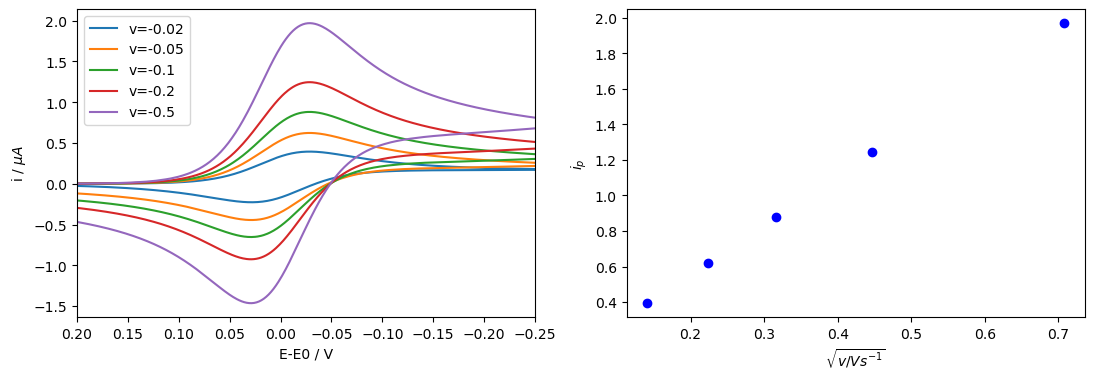

In [12]:
# solução para várias velocidades de varredura.
f=38.9217
solver = pybamm.ScipySolver()
currents = []
peak_currents = []
potentials = []
labels=[]
elow=0.3 # init potential
ehigh=-0.3 # end potential
vs = [-0.02, -0.05, -0.1, -0.2, -0.5] # sweep rates
for v in vs:
    tf=2*(ehigh-elow)/v
    t = np.linspace(0, tf, 1000)
    solution = solver.solve(model, t, inputs={"Init Potential [V]": elow, 
                                              "Final Potential [V]": ehigh, 
                                              "Standard Potential [V]": 0, 
                                              "Scan rate [V.s-1]": v})
    Na_sol = solution["Flux of O"]
    e_sol = solution["Applied potential"]
    i = -Na_sol(solution.t,x=0)
    peak = np.max(i)
    E = e_sol(solution.t)
    currents.append(i)
    potentials.append(E)
    peak_currents.append(peak)
    labels.append(str(v))

# plot
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(13, 4))

ax1.plot(potentials[0],currents[0],label="v="+labels[0])
ax1.plot(potentials[1],currents[1],label="v="+labels[1])
ax1.plot(potentials[2],currents[2],label="v="+labels[2])
ax1.plot(potentials[3],currents[3],label="v="+labels[3])
ax1.plot(potentials[4],currents[4],label="v="+labels[4])
ax1.set_xlabel("E-E0 / V")
ax1.set_ylabel("i / $\mu A$")
ax1.set_xlim([0.2,-0.25])
#ax1.set_ylim([0,6])
#plt.tight_layout()

ax2.plot(list(map(np.sqrt,map(abs,vs))),peak_currents,"b o")
ax2.set_xlabel("$\sqrt{v / Vs^{-1}}$")
ax2.set_ylabel("$i_p$")

ax1.legend(loc="upper left")
plt.show()

In [13]:
# simulação da voltametria.
from ipywidgets import interact, Text, Layout, Button, Output
from IPython.display import display, clear_output

# solução
solver = pybamm.ScipySolver()
t = np.linspace(0.00001, 1, 1000)
f = 38.9217

output = Output() # define um widget output para capturar o gráfico e depois mostrá-lo com display

def plot_solution(ei,ef,e0, v):
    with output:
        clear_output(wait=True) # limpa gráficos anteriormente gerados
        try:
            ei = float(ei)  # Garante que a entrada seja um número válido.
            ef = float(ef)
            e0 = float(e0)
            v = float(v)
        except ValueError:
            print("Por favor, insira um número válido")
            return
    
        tf=2*(ef-ei)/v
        t = np.linspace(0, tf, 1000)
        solution = solver.solve(model, t, inputs={"Init Potential [V]": ei, 
                                              "Final Potential [V]": ef, 
                                              "Standard Potential [V]": e0, 
                                              "Scan rate [V.s-1]": v})
        Na_sol = solution["Flux of O"]
        e_sol = solution["Applied potential"]
        i = -Na_sol(solution.t,x=0)
        E = e_sol(solution.t)
        
    
        # plot
        fig, ax1 = plt.subplots()

        ax1.plot(E,i,"r-",linewidth=1.5)
        ax1.set_xlabel("E / V")
        ax1.set_ylabel("Corrente")
        ax1.set_xlim([ei,ef])
        plt.tight_layout()
        plt.show()

# Cria um Text widget para número de pontos
v_input = Text(value='-0.1', description= 'entre $v$ em $V\cdot s^{-1}$:', continuous_update=False,
                style={'description_width':'initial'})

# Cria um Text widget para entrada do potencial inicial
ei_input = Text(value='0.5', description= 'entre $ E_i $ em V :', continuous_update=False,
                style={'description_width':'initial'})

# Cria um Text widget para entrada do potencial final
ef_input = Text(value='-0.5', description= 'entre $ E_f $ em V :', continuous_update=False,
                style={'description_width':'initial'})

# Cria um Text widget para entrada do potencial padrão
e0_input = Text(value='0', description= 'entre $ E^0 $ em V :', continuous_update=False,
                style={'description_width':'initial'})

# Cria um botão para recalcular a função
run_button = Button(description="Recalcular")

# Define um manipulador de eventos para o click no botão
def on_button_click(b):
    ei = ei_input.value
    ef = ef_input.value
    e0 = e0_input.value
    v = v_input.value
    if ei and ef and e0 and v:  # Ensure both values are entered
        plot_solution(ei,ef,e0,v)
        
# Link o click do botão com o manipulador de eventos
run_button.on_click(on_button_click)

# Mostra o gráfico default na primeira execução
plot_solution(ei_input.value, ef_input.value,e0_input.value,v_input.value)

# mostra os widgets, incluindo o output
display(ei_input, ef_input, e0_input, v_input, run_button, output)


Text(value='0.5', continuous_update=False, description='entre $ E_i $ em V :', style=TextStyle(description_wid…

Text(value='-0.5', continuous_update=False, description='entre $ E_f $ em V :', style=TextStyle(description_wi…

Text(value='0', continuous_update=False, description='entre $ E^0 $ em V :', style=TextStyle(description_width…

Text(value='-0.1', continuous_update=False, description='entre $v$ em $V\\cdot s^{-1}$:', style=TextStyle(desc…

Button(description='Recalcular', style=ButtonStyle())

Output()